In [1]:
import torch
import functions

device = 'cuda' if torch.cuda.is_available() else 'cpu'


ModuleNotFoundError: No module named 'functions'

In [ ]:
df, df_temp_all = functions.make_dataframe(120, 60)

In [ ]:
df_temp_all

,TEMP,TIME
0,286.797,0
1,287.082,1
2,285.938,2
3,285.772,3
4,286.357,4
...,...,...
664791,865.029,664791
664792,864.985,664792
664793,865.048,664793
664794,865.040,664794


## LSTM

In [ ]:
import numpy as np
from copy import deepcopy as dc
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    

    for i in range(1,n_steps+1):
        df[f'TEMP(t-{i})'] = df['TEMP'].shift(i)

    df.dropna(inplace=True)
    return df

lookback = 5
shifted_df = prepare_dataframe_for_lstm(df_temp_all, lookback)
shifted_df.drop(columns='TIME', inplace = True)
X = shifted_df.values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

y = X[:, 0]
X = X[:, 1:]


train_len = int(len(X) * 0.8)

X_train = X[:train_len]
X_test = X[train_len:]
y_train = y[:train_len]
y_test = y[train_len:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x,(h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(1, 10, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
    model.train(True)
    print(f"Epoch : {epoch + 1}")
    training_loss = 0.0

    for batch_index, batch in enumerate(train_dataloader):
        X, y = batch[0].to(device), batch[1].to(device)

        y_pred = model(X)
        loss = criterion(y_pred, y)
        training_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 1000 == 999:
            print("Batch {0}, Training_loss : {1}". format(batch_size +1, loss))

        training_loss = 0.0

In [ ]:
def validate_one_epoch():
    model.train(False)
    validation_loss = 0.0

    for batch_index, batch in enumerate(test_dataloader):
        X, y = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            y_pred = model(X)
            loss = criterion(y, y_pred)
            validation_loss += loss.item()

    total_loss = validation_loss / len(test_dataloader)

    print("Val loss : {}".format(total_loss))
    print("***********************************************")

In [ ]:
learning_rate = 0.001
num_epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch : 1


Batch 513, Training_loss : 6.737629882991314e-05
Val loss : 0.002665525542173642
***********************************************
Epoch : 2
Batch 513, Training_loss : 2.0780062186531723e-05
Val loss : 0.0010527513440767786
***********************************************
Epoch : 3
Batch 513, Training_loss : 2.8446434043871704e-06
Val loss : 0.00018778710576113484
***********************************************
Epoch : 4
Batch 513, Training_loss : 1.0070633607028867e-06
Val loss : 3.5560497362068914e-05
***********************************************
Epoch : 5
Batch 513, Training_loss : 5.928134214627789e-07
Val loss : 2.8840364741902556e-05
***********************************************
Epoch : 6
Batch 513, Training_loss : 5.927418555984332e-07
Val loss : 3.5685837428490486e-05
***********************************************
Epoch : 7
Batch 513, Training_loss : 1.0370554264227394e-06
Val loss : 4.450539145728691e-05
***********************************************
Epoch : 8
Batch 513, Tr

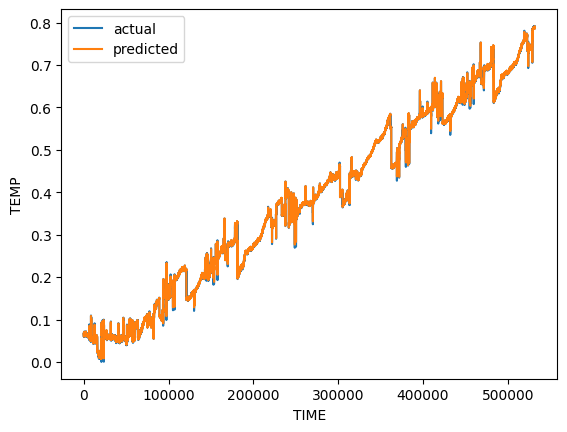

In [ ]:
import matplotlib.pyplot as plt
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label = 'actual')
plt.plot(predicted, label = 'predicted')
plt.xlabel('TIME')
plt.ylabel('TEMP')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score
print("R2 : ", r2_score(predicted, y_train))


R2 :  0.9999669096112418


In [ ]:
train_prediction = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback +1))
dummies[:, 0] = train_prediction
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
dummies = np.zeros((y_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten(0)
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])

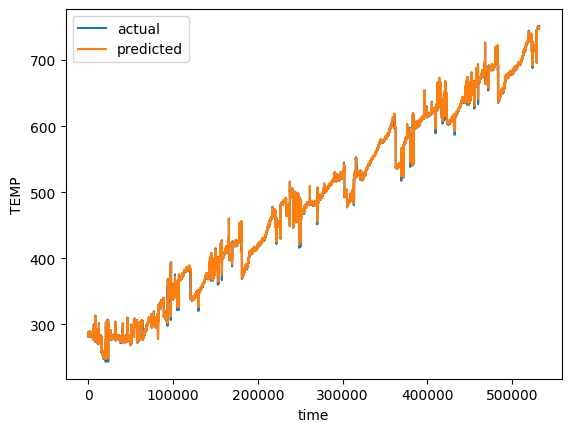

In [ ]:
plt.plot(new_y_train, label='actual')
plt.plot(train_predictions, label='predicted')
plt.xlabel('time')
plt.ylabel('TEMP')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score
print("R2 : ", r2_score(train_predictions, new_y_train))

R2 :  0.9999669096112342


In [ ]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([748.08598403, 747.88600564, 748.26599136, ..., 865.04801423,
       865.04001815, 864.97199413])

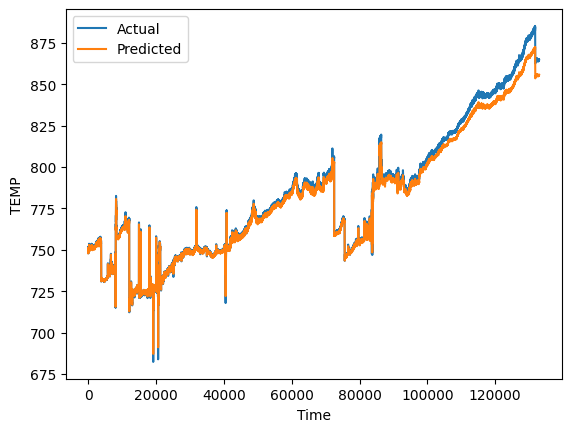

In [ ]:
plt.plot(new_y_test, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('TEMP')
plt.legend()
plt.show()

In [ ]:
print(r2_score(new_y_test, test_predictions))

0.9911487669450895


In [ ]:
cd ..

c:\Users\Sejong\Desktop\hanhwa


# 11.28 여기서부터 실행

In [ ]:
cd ..

c:\Users\Sejong\Desktop\hanhwa


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
warnings.filterwarnings('ignore')
from function_file.ML_functions import make_dataframe

from sklearn.model_selection import train_test_split

In [ ]:
_, df = make_dataframe(60, 20)
df

,TEMP,TIME
0,286.797,0
1,287.082,1
2,285.938,2
3,285.772,3
4,286.357,4
...,...,...
664791,865.029,664791
664792,864.985,664792
664793,865.048,664793
664794,865.040,664794


In [ ]:
import torch.nn as nn
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


lr = 0.001
num_epochs = 100
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)
batch_size = 512

def train_one_epoch():
    model.train(True)
    print(f"Epoch : {epoch + 1}")
    training_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(X_batch)
        loss = criterion(output, y_batch)
        training_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 1000 == 999:
            #avg_loss_cross_batches = training_loss / 1000
            #print("Batch {0}, Training Loss : {1}".format(batch_size+1, loss))
            pass
        training_loss = 0.0

def validate_one_epoch():
    model.train(False)
    validation_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(X_batch)
            loss = criterion(output, y_batch)
            validation_loss += loss.item()

    avg_loss_across_batches = validation_loss / len(test_loader)

    #print('Val loss : {0}'.format(avg_loss_across_batches))

In [ ]:
from function_file.deeplearning_function import DEEPLEARNING, plot_prediction
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

lookback_list = [10,20,60,100]
FB_list = ['back']
for lookback in lookback_list:
    for fb in FB_list:
        model = LSTM(1,4,1)
        model.to(device)
        train_loader, test_loader, X_test, y_test = DEEPLEARNING(df, lookback, batch_size = batch_size, front_or_back=fb)
        print("lookback size : ", lookback)
        print(fb)
        for epoch in range(num_epochs):
            train_one_epoch()
            validate_one_epoch()

        print("***********************************************")
        test_predictions, new_y_test = plot_prediction(model, X_test, y_test, lookback)

        plt.plot(new_y_test, label='Actual')
        plt.plot(test_predictions, label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('TEMP')
        plt.legend()
        plt.show()
        print(r2_score(new_y_test, test_predictions))
        print(mean_absolute_error(new_y_test, test_predictions))
        print(mean_squared_error(new_y_test, test_predictions))